Using device: mps
Loaded features: torch.Size([2000, 32, 2048])
Loaded labels: torch.Size([2000])
Split into: 1400 train, 300 val, 300 test
LSTMClassifier(
  (lstm): LSTM(2048, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attn_pool): AttentionPool(
    (attn): Linear(in_features=1024, out_features=1, bias=True)
  )
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)
Epoch [1/30] - Loss: 0.5059, Val Acc: 0.8300
Epoch [2/30] - Loss: 0.4592, Val Acc: 0.8500
Epoch [3/30] - Loss: 0.4602, Val Acc: 0.8467
Epoch [4/30] - Loss: 0.4573, Val Acc: 0.8533
Epoch [5/30] - Loss: 0.4577, Val Acc: 0.8400
Epoch [6/30] - Loss: 0.4511, Val Acc: 

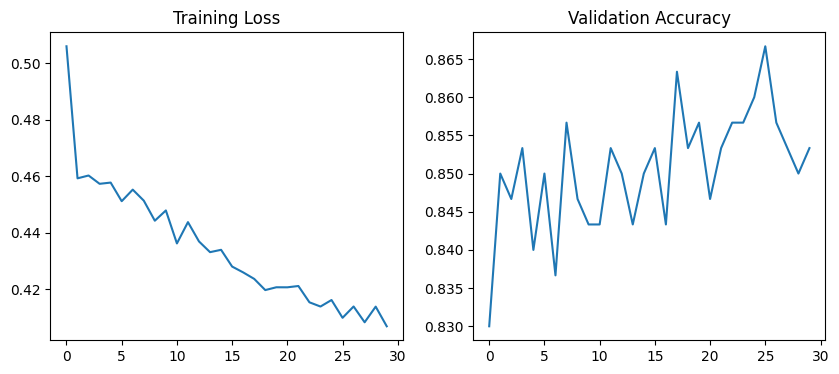

🎯 Final Test Accuracy: 0.8300


In [9]:

# LSTM Deepfake Classifier Training
# ================================


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Device configuration (for Mac M1/M2/M3 with MPS support)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load extracted features and labels
features = torch.load("all_features.pt")  # shape: (N, T, 2048)
labels = torch.load("all_labels.pt")      # shape: (N,)
print("Loaded features:", features.shape)
print("Loaded labels:", labels.shape)

# Wrap in dataset
dataset = TensorDataset(features, labels)

# Train/val/test split (70/15/15)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
print(f"Split into: {train_size} train, {val_size} val, {test_size} test")

# DataLoaders
BATCH_SIZE = 8
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE)

class AttentionPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)  # because bidirectional → 2×hidden_dim

    def forward(self, lstm_out):
        # lstm_out: [B, T, H*2]
        scores = self.attn(lstm_out)              # [B, T, 1]
        weights = torch.softmax(scores, dim=1)    # [B, T, 1]
        context = (weights * lstm_out).sum(dim=1) # [B, H*2]
        return context


# LSTM model definition
class LSTMClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        hidden_dim = 512
        self.lstm = nn.LSTM(
            2048, hidden_dim, num_layers=2,
            batch_first=True, bidirectional=True, dropout=0.3
        )
        self.attn_pool = AttentionPool(hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        # x: [B, T, 2048]
        lstm_out, _ = self.lstm(x)               # [B, T, H*2]
        attn_vec = self.attn_pool(lstm_out)      # [B, H*2]
        attn_vec = self.layer_norm(attn_vec)
        return self.fc(attn_vec)


model = LSTMClassifier().to(device)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Training loop with early stopping
NUM_EPOCHS = 30
PATIENCE = 5
best_val_acc = 0.0
epochs_no_improve = 0

train_losses = []
val_accuracies = []

best_model_state = None

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # gradient clipping
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            _, predicted = torch.max(outputs, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    # # Early stopping logic
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     epochs_no_improve = 0
    #     best_model_state = model.state_dict()
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve >= PATIENCE:
    #         print(f"⏹️ Early stopping at epoch {epoch+1}")
    #         break

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_lstm_model.pth")


    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

# Load best model
if best_model_state:
    model.load_state_dict(best_model_state)

# Plot training loss and val accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Loss')
plt.title("Training Loss")
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Acc')
plt.title("Validation Accuracy")
plt.show()

# Final test accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

print(f"🎯 Final Test Accuracy: {correct / total:.4f}")
